In [292]:
import numpy as np
import pandas as pd
from datetime import datetime
import time
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')
from statsmodels.tsa.ar_model import AR, ARResults
from statsmodels.tsa.ar_model import AutoReg
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')
import gc
import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [293]:
census = pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv")
test= pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv",parse_dates=['first_day_of_month'])
train=pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv",parse_dates=["first_day_of_month"])


In [294]:
train = train[train["microbusiness_density"]<50]

In [297]:
sorted(list(set(census["cfips"].unique()) - set(train["cfips"].unique())))

TypeError: 'list' object is not callable

In [288]:
sorted(list(set(census["cfips"].unique()) - set(test["cfips"].unique())))

TypeError: 'list' object is not callable

In [298]:
list_ = [2158, 2261, 31117, 35039, 46102, 48243, 48301, 51580, 51640, 51690]
for i in list:
     census=census[~census.cfips == i]


In [299]:
test = pd.merge(test, census, how="left", on="cfips")
train = pd.merge(train, census, how="left", on="cfips")

In [300]:
test.isnull().sum()

row_id                       0
cfips                        0
first_day_of_month           0
pct_bb_2017              25080
pct_bb_2018              25080
pct_bb_2019              25080
pct_bb_2020              25080
pct_bb_2021              25080
pct_college_2017         25080
pct_college_2018         25080
pct_college_2019         25080
pct_college_2020         25080
pct_college_2021         25080
pct_foreign_born_2017    25080
pct_foreign_born_2018    25080
pct_foreign_born_2019    25080
pct_foreign_born_2020    25080
pct_foreign_born_2021    25080
pct_it_workers_2017      25080
pct_it_workers_2018      25080
pct_it_workers_2019      25080
pct_it_workers_2020      25080
pct_it_workers_2021      25080
median_hh_inc_2017       25080
median_hh_inc_2018       25080
median_hh_inc_2019       25080
median_hh_inc_2020       25080
median_hh_inc_2021       25080
dtype: int64

In [291]:
train.isnull().sum()

row_id                        0
cfips                         0
county                        0
state                         0
first_day_of_month            0
microbusiness_density         0
active                        0
pct_bb_2017              122115
pct_bb_2018              122115
pct_bb_2019              122115
pct_bb_2020              122115
pct_bb_2021              122115
pct_college_2017         122115
pct_college_2018         122115
pct_college_2019         122115
pct_college_2020         122115
pct_college_2021         122115
pct_foreign_born_2017    122115
pct_foreign_born_2018    122115
pct_foreign_born_2019    122115
pct_foreign_born_2020    122115
pct_foreign_born_2021    122115
pct_it_workers_2017      122115
pct_it_workers_2018      122115
pct_it_workers_2019      122115
pct_it_workers_2020      122115
pct_it_workers_2021      122115
median_hh_inc_2017       122115
median_hh_inc_2018       122115
median_hh_inc_2019       122115
median_hh_inc_2020       122115
median_h

In [260]:
test.dropna(inplace=True)
train.dropna(inplace=True)

<AxesSubplot:>

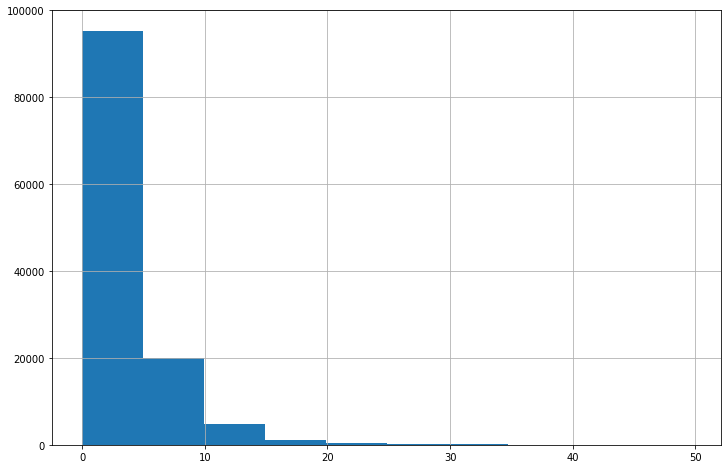

In [261]:
train["microbusiness_density"].hist(figsize=(12,8))

In [262]:
def create_date_features(df):
    df['month'] = df.first_day_of_month.dt.month
    df['day_of_month'] = df.first_day_of_month.dt.day
    df['day_of_year'] = df.first_day_of_month.dt.dayofyear
    df['week_of_year'] = df.first_day_of_month.dt.weekofyear
    df['day_of_week'] = df.first_day_of_month.dt.dayofweek
    df['year'] = df.first_day_of_month.dt.year
    df["is_wknd"] = df.first_day_of_month.dt.weekday // 4
    df['is_month_start'] = df.first_day_of_month.dt.is_month_start.astype(int)
    df['is_month_end'] = df.first_day_of_month.dt.is_month_end.astype(int)
    return df

train = create_date_features(train)
test=create_date_features(test)

In [263]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [264]:
X = train.drop(columns={"row_id", "first_day_of_month", "microbusiness_density", "county", "state", "active"})
y = train["microbusiness_density"]

x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

x_pred = test.drop(columns={"row_id", "first_day_of_month"})

In [265]:
model = XGBRegressor(n_estimators=4500, eval_metric=smape, early_stopping_rounds=30, learning_rate=0.1)
model.fit(x_train, y_train,  
             eval_set=[(x_valid, y_valid)],
             verbose=100)

y_pred = model.predict(x_pred)

[0]	validation_0-rmse:4.41193	validation_0-smape:105.60253
[100]	validation_0-rmse:1.01247	validation_0-smape:21.26752
[200]	validation_0-rmse:0.74740	validation_0-smape:14.95116
[300]	validation_0-rmse:0.62391	validation_0-smape:11.44840
[400]	validation_0-rmse:0.56324	validation_0-smape:9.13576
[500]	validation_0-rmse:0.52747	validation_0-smape:7.79480
[600]	validation_0-rmse:0.50566	validation_0-smape:6.91401
[700]	validation_0-rmse:0.48994	validation_0-smape:6.33600
[800]	validation_0-rmse:0.47997	validation_0-smape:5.93379
[900]	validation_0-rmse:0.46879	validation_0-smape:5.58975
[1000]	validation_0-rmse:0.45900	validation_0-smape:5.29981
[1100]	validation_0-rmse:0.45678	validation_0-smape:5.09662
[1200]	validation_0-rmse:0.45188	validation_0-smape:4.92871
[1300]	validation_0-rmse:0.44627	validation_0-smape:4.78787
[1400]	validation_0-rmse:0.44721	validation_0-smape:4.66908
[1500]	validation_0-rmse:0.44633	validation_0-smape:4.55835
[1600]	validation_0-rmse:0.44231	validation_0-s

In [266]:
test["microbusiness_density"] = pd.Series(y_pred).astype(float)
test[["row_id", "microbusiness_density"]].to_csv("submission.csv", index=False)